In [14]:
import os
import sys
import pandas as pd
import geopandas as gpd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    roc_curve,
    RocCurveDisplay,
    auc,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

sys.path.append("../utils")


In [15]:
data = pd.read_csv(
    "/capstone/wildfire_prep/data/PUZZLE_PIECES/assembled_puzzle.csv"
).drop(columns=["basemap_id", 'total_rain_three_months_prior'])

In [16]:
# Remove Mosaiks from dataset for testing

mosaiks86 = data[
    [
        "inspection_id",
        "maj_landcover_code_x",
        "maj_landcover_code_y",
        "status",
        "structure_code",
        "current_month_rain",
        "previous_month_rain",
        "two_months_prior_rain",
        "mean_ndvi"
    ]
]

data = mosaiks86
data.columns


Index(['inspection_id', 'maj_landcover_code_x', 'maj_landcover_code_y',
       'status', 'structure_code', 'current_month_rain', 'previous_month_rain',
       'two_months_prior_rain', 'mean_ndvi'],
      dtype='object')

In [17]:
print(data.shape)
print(data.columns)
data.head()

(67580, 9)
Index(['inspection_id', 'maj_landcover_code_x', 'maj_landcover_code_y',
       'status', 'structure_code', 'current_month_rain', 'previous_month_rain',
       'two_months_prior_rain', 'mean_ndvi'],
      dtype='object')


,inspection_id,maj_landcover_code_x,maj_landcover_code_y,status,structure_code,current_month_rain,previous_month_rain,two_months_prior_rain,mean_ndvi
0,1,304.0,557,0,100,0.28,2.18,0.19,0.346535
1,2,304.0,304,0,101,1.46,0.08,3.19,0.463867
2,3,303.0,303,0,101,1.46,0.08,3.19,0.345345
3,4,39.0,304,0,100,1.46,0.08,3.19,0.278349
4,5,304.0,304,0,101,5.14,1.67,NaN,0.574557


## Downsample Majority Class Approach


In [18]:
X = data.drop("status", axis=1)
y = data["status"]

upsample_data_ids = X.inspection_id

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

train = pd.concat([X_train, y_train], axis=1)

majority = train[train.status == 0]
minority = train[train.status == 1]

n_majority_desired = len(minority) * 3
majority_downsampled = majority.sample(
    n=n_majority_desired, replace=False, random_state=42
)

train_balanced = (
    pd.concat([majority_downsampled, minority])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

X_train = train_balanced.drop("status", axis=1).drop(columns="inspection_id")
y_train = train_balanced["status"]

X_test = X_test.drop(columns="inspection_id")

print(f"Shape of compliant:", majority.shape)
print(f"Shape of non-compliant:", minority.shape)

print(f"N_minority desired:", int(len(majority) * 3))

print("Shapes:")
print(" Downsampled X_train:", X_train.shape)
print(" Downsampled y_train:", y_train.shape)
print(" Downsampled X_test: ", X_test.shape)
print(" Downsampled y_test: ", y_test.shape)

print("\nTrain distribution after up-sampling:")
print(y_train.value_counts(normalize=True))

X_train


Shape of compliant: (53730, 9)
Shape of non-compliant: (334, 9)
N_minority desired: 161190
Shapes:
 Downsampled X_train: (1336, 7)
 Downsampled y_train: (1336,)
 Downsampled X_test:  (13516, 7)
 Downsampled y_test:  (13516,)

Train distribution after up-sampling:
status
0    0.75
1    0.25
Name: proportion, dtype: float64


,maj_landcover_code_x,maj_landcover_code_y,structure_code,current_month_rain,previous_month_rain,two_months_prior_rain,mean_ndvi
0,303.0,582,102,NaN,1.09,0.05,0.350208
1,581.0,304,102,0.01,0.51,0.92,0.295422
2,303.0,582,102,0.01,0.02,NaN,0.561608
3,556.0,556,101,0.03,NaN,NaN,0.305255
4,582.0,582,102,0.34,0.45,0.07,0.112677
...,...,...,...,...,...,...,...
1331,581.0,304,102,0.19,1.95,0.22,-0.017809
1332,581.0,303,100,NaN,NaN,0.01,0.331064
1333,556.0,581,104,NaN,NaN,NaN,0.401912
1334,582.0,303,102,0.06,1.88,0.16,-0.011619


## Upsample Minority Class Approach


In [19]:
X = data.drop("status", axis=1)
y = data["status"]

# Save inspection_ids from the data, in case we need them later
upsample_data_ids = X.inspection_id

# split data, as usual. 20% test data split.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Recombine just the train fold
train = pd.concat([X_train, y_train], axis=1)

# Up-sample the minority inside train
majority = train[train.status == 0]
minority = train[train.status == 1]
n_min = int(len(majority) / 3)

minority_upsampled = minority.sample(n=n_min, replace=True, random_state=42)

train_balanced = (
    pd.concat([majority, minority_upsampled])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

X_train = train_balanced.drop("status", axis=1).drop(columns="inspection_id")
y_train = train_balanced["status"]
X_test = X_test.drop(columns="inspection_id")

# Check majority/minority sizes
print(f"Shape of compliant:", majority.shape)
print(f"Shape of non-compliant:", minority.shape)

print(f"N_minority desired:", int(len(majority) / 3))

print("Shapes:")
print(" Upsampled X_train:", X_train.shape)
print(" Upsampled y_train:", y_train.shape)
print(" Upsampled X_test: ", X_test.shape)
print(" Upsampled y_test: ", y_test.shape)

print("\nTrain distribution after up-sampling:")
print(y_train.value_counts(normalize=True))

X_train


Shape of compliant: (53730, 9)
Shape of non-compliant: (334, 9)
N_minority desired: 17910
Shapes:
 Upsampled X_train: (71640, 7)
 Upsampled y_train: (71640,)
 Upsampled X_test:  (13516, 7)
 Upsampled y_test:  (13516,)

Train distribution after up-sampling:
status
0    0.75
1    0.25
Name: proportion, dtype: float64


,maj_landcover_code_x,maj_landcover_code_y,structure_code,current_month_rain,previous_month_rain,two_months_prior_rain,mean_ndvi
0,581.0,581,102,0.02,NaN,NaN,0.329122
1,583.0,582,102,0.07,0.01,NaN,0.101521
2,39.0,581,100,NaN,0.01,0.07,0.305236
3,304.0,303,101,0.01,0.01,0.43,0.206588
4,581.0,556,107,1.09,NaN,NaN,0.396787
...,...,...,...,...,...,...,...
71635,581.0,557,106,0.01,NaN,0.02,0.424183
71636,581.0,556,102,6.58,1.44,NaN,0.444544
71637,581.0,303,102,0.17,NaN,0.03,0.334437
71638,581.0,581,102,0.26,1.37,NaN,0.225500


## Random Forest Classifier Model


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 200
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 20
Fitting 3 folds for each of 10 candidates, totalling 30 fits
----------
iter: 1
n_candidates: 4
n_resources: 60
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 180
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters: {'max_depth': 14, 'max_features': 0.2, 'min_samples_leaf': 5, 'n_estimators': 180}
Actual non-compliant count: 84
Predicted non-compliant count: 0
Accuracy: 0.9937851435335898


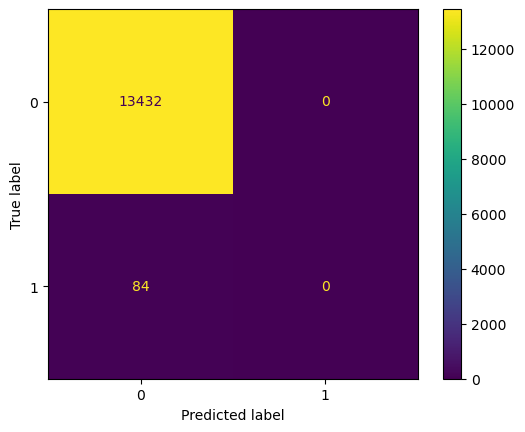

In [53]:

param_dist = {
    "max_depth": randint(1, 20),
    "min_samples_leaf": [1, 5, 10, 20],
    "max_features": ["sqrt", "log2", 0.2, 0.5],
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1, bootstrap=True)

# Halving random search
halving_search = HalvingRandomSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    resource="n_estimators",
    min_resources=20,
    max_resources=200,
    factor=3,
    cv=3,
    scoring="precision",
    n_jobs=1,
    verbose=1,
    refit=True,
)

halving_search.fit(X_train, y_train)
print("Best parameters:", halving_search.best_params_)

# Use the refitted best model
best_rf = halving_search.best_estimator_

# Predict with threshold
y_scores = best_rf.predict_proba(X_test)[:, 1]
threshold = 0.901
y_pred = (y_scores >= threshold).astype(int)

# Metrics and confusion matrix
print(f"Actual non-compliant count: {y_test.sum()}")
print(f"Predicted non-compliant count: {y_pred.sum()}")
print("Accuracy:", accuracy_score(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


Feature importances:
 mean_ndvi                0.305365
maj_landcover_code_y     0.152447
two_months_prior_rain    0.124204
previous_month_rain      0.123076
current_month_rain       0.109450
dtype: float64


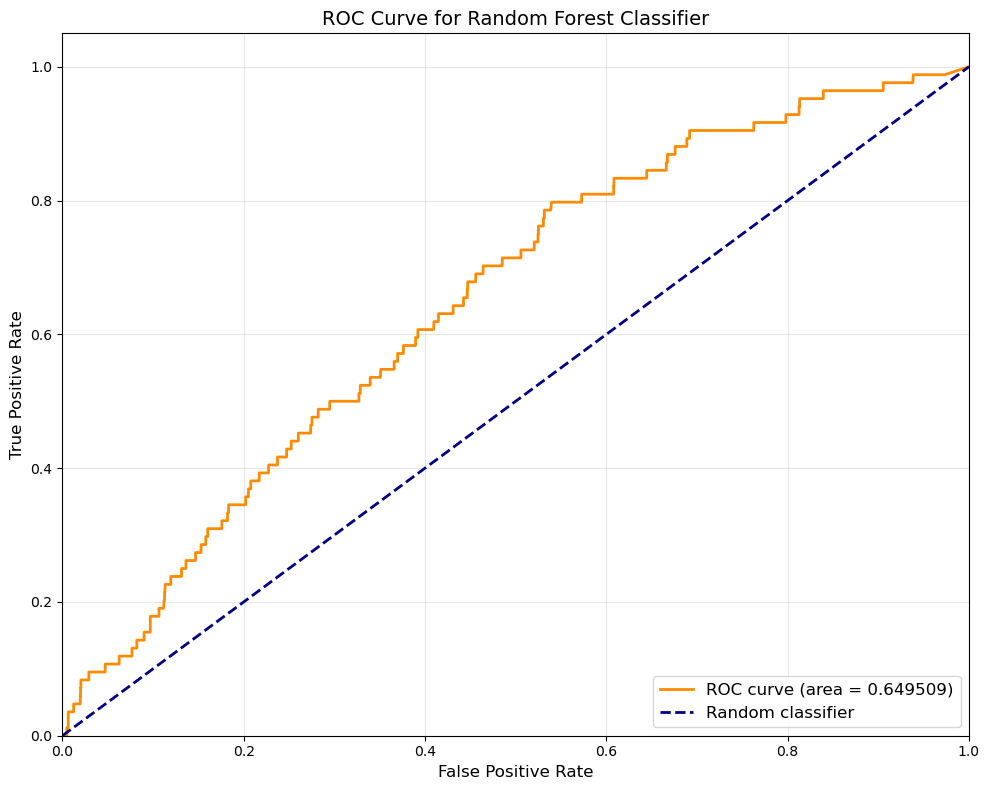

ROC AUC Score: 0.6495


In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

feature_importances = pd.Series(
    best_rf.feature_importances_, index=X_train.columns
).sort_values(ascending=False)
print(f"Feature importances:\n", feature_importances.head())

# Generate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Create the plot
plt.figure(figsize=(10, 8))

# Plot ROC curve
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.6f})")

# Plot baseline
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random classifier")

# Style the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve for Random Forest Classifier", fontsize=14)
plt.legend(loc="lower right", fontsize=12)

# Add grid
plt.grid(alpha=0.3)

# Display the plot
plt.tight_layout()
plt.show()

# Print numeric results for reference
print(f"ROC AUC Score: {roc_auc:.4f}")


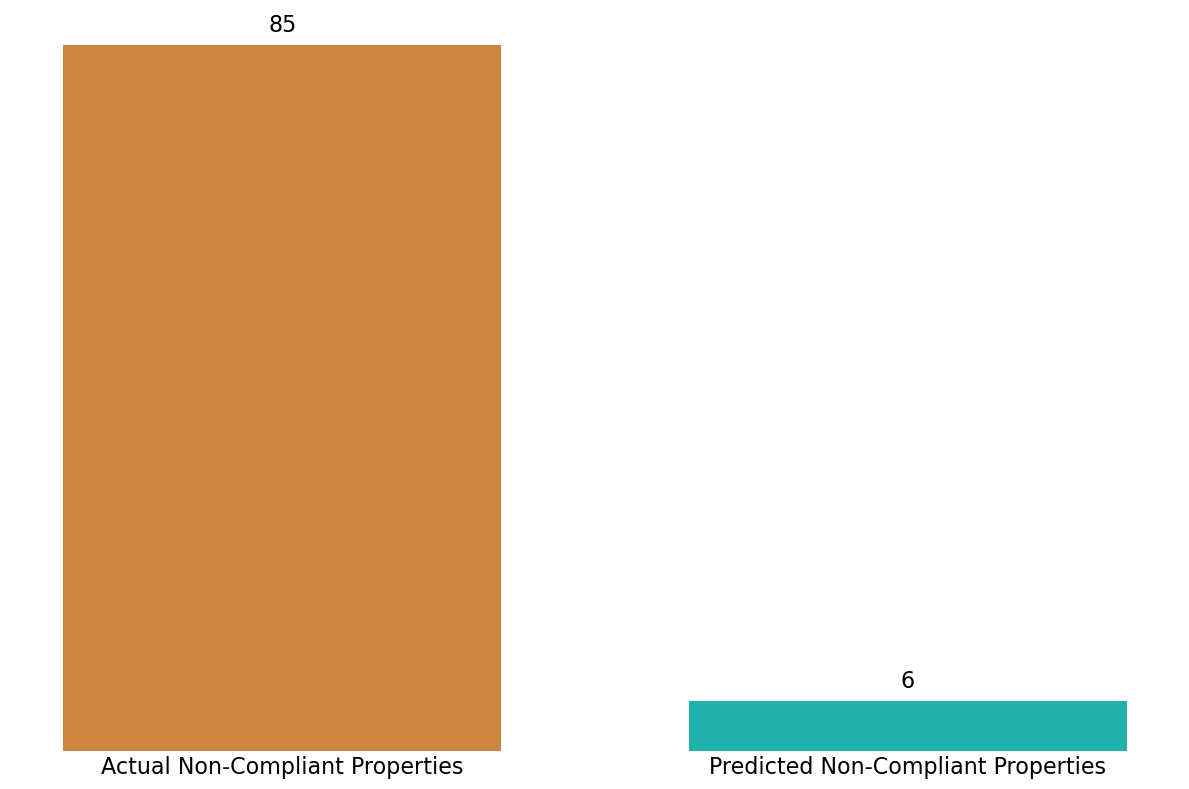

In [54]:
import matplotlib.pyplot as plt
import numpy as np

actual_noncompliant = 85
predicted_noncompliant = 6

# Labels and positions
labels = ["Actual Non-Compliant Properties", "Predicted Non-Compliant Properties"]
x = np.array([0, 1])
width = 0.7

# Colors: orange for actual, steelblue for predicted
colors = ["peru", "lightseagreen"]

# Create figure & axes with transparent background
fig, ax = plt.subplots(figsize=(12, 8), facecolor="none")
ax.set_facecolor("none")
fig.patch.set_alpha(0)

# Remove frame
for spine in ax.spines.values():
    spine.set_visible(False)

# Plot bars
bars = ax.bar(x, [actual_noncompliant, predicted_noncompliant], width, color=colors)

# Add count labels on top
for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, h + 1, f"{int(h)}", ha="center", va="bottom", fontsize = 16
    )

# Keep x-axis labels but hide the tick markers
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=16)
ax.tick_params(axis="x", length=0)

# Keep the y-axis title but hide tick marks and labels
ax.set_ylabel("")
ax.tick_params(axis="y", which="both", length=0, labelleft=False)

# (Optionally set a title)
ax.set_title("")

plt.tight_layout()
plt.show()
